In [1]:
pip install statsmodels
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# Carga y Tratamiento de datos

Leo los datos desde el csv que incluye solo fechas y precio de soja. Llamo price a la columna de precios y la guardo en la variable "y".
Ploteo la serie para verificar que estè ok

In [2]:
import numpy as np

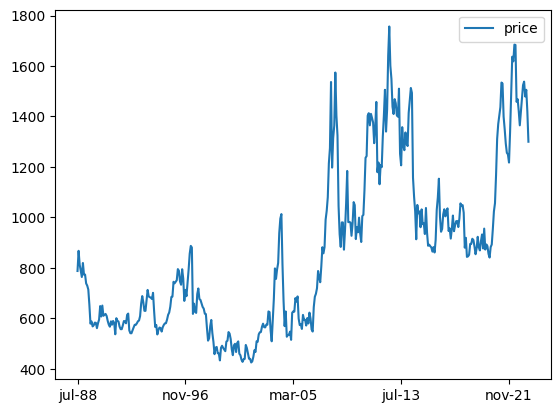

In [165]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('precios_cbot.csv', names=['price'], header=0)
y = df.price

df.plot();

Saco las fechas del ìndice para convertirlo a formato y tipo fecha:

In [166]:
df.reset_index(inplace=True)

In [167]:
df.columns=["date","price"]

In [168]:
def convertir_fecha(fecha):
    mes, anio = fecha.split('-')
    mapeo_meses = {'ene': '01', 'feb': '02', 'mar': '03', 'abr': '04', 'may': '05', 'jun': '06',
                   'jul': '07', 'ago': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dic': '12'}
    mes_num = mapeo_meses[mes]
    return pd.to_datetime(mes_num + '-' + anio, format='%m-%y')

In [169]:
fechas_convertidas = [convertir_fecha(fecha) for fecha in df["date"]]

In [170]:
df["date"]=fechas_convertidas

In [171]:
type(df.index)

pandas.core.indexes.range.RangeIndex

Vuelvo a definir la fecha como ìndice una vez que tiene ok formato y tipo

In [172]:
df.set_index(["date"],inplace=True)

In [173]:
df.index

DatetimeIndex(['1988-07-01', '1988-08-01', '1988-09-01', '1988-10-01',
               '1988-11-01', '1988-12-01', '1989-01-01', '1989-02-01',
               '1989-03-01', '1989-04-01',
               ...
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01'],
              dtype='datetime64[ns]', name='date', length=419, freq=None)

Verifico que no haya valores repetidos, para poder darle frecuencia mensual a la serie:

*MS significa Month Start (frecuencia mensual partiendo del primer día del mes)*

In [174]:
df.reset_index()["date"].value_counts()

date
1988-07-01    1
2014-09-01    1
2012-05-01    1
2012-04-01    1
2012-03-01    1
             ..
1999-11-01    1
1999-10-01    1
1999-09-01    1
1999-08-01    1
2023-05-01    1
Name: count, Length: 419, dtype: int64

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [176]:
df.index.freq = 'MS'

In [177]:
df.index

DatetimeIndex(['1988-07-01', '1988-08-01', '1988-09-01', '1988-10-01',
               '1988-11-01', '1988-12-01', '1989-01-01', '1989-02-01',
               '1989-03-01', '1989-04-01',
               ...
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01'],
              dtype='datetime64[ns]', name='date', length=419, freq='MS')

## Verificación de seasonality, stationarity y residuos

Verifico estacionalidad de la serie para justificar aplicación de SARIMA en lugar de ARIMA y verifico existencia de tendencia + distribución de residuos:

In [16]:
decomposition = seasonal_decompose(df["price"], model='additive')

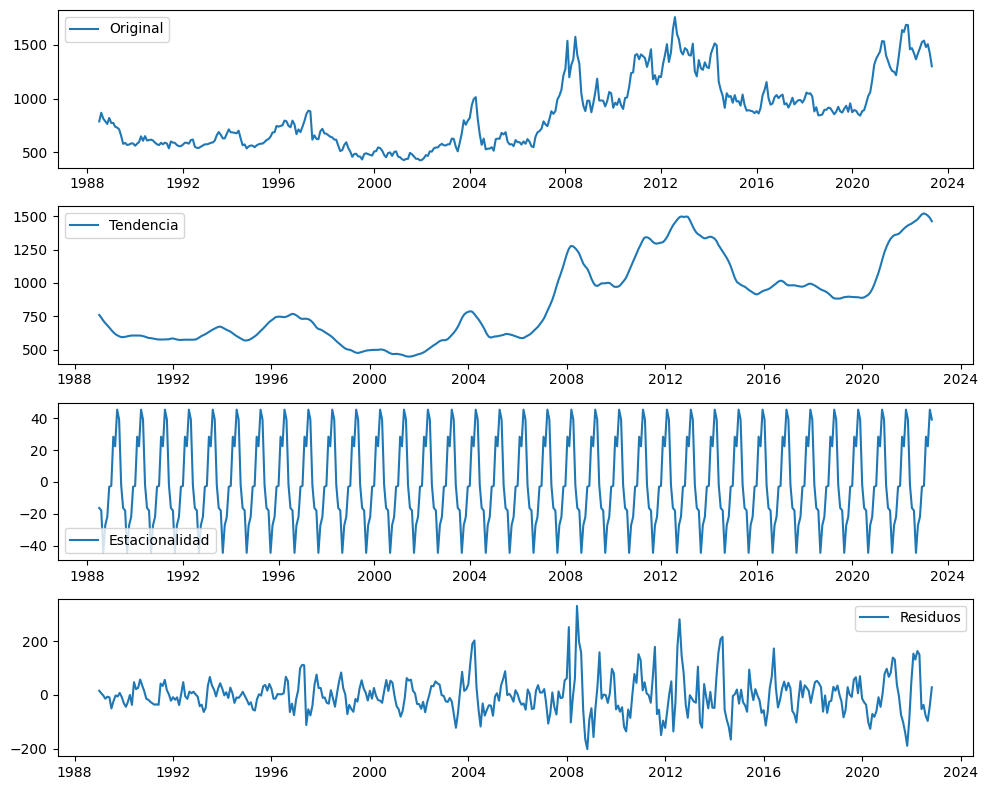

In [17]:
# Gráfica de los componentes de la descomposición
fig, ax = plt.subplots(4, 1, figsize=(10, 8))

ax[0].plot(df['price'], label='Original')
ax[0].legend(loc='best')

ax[1].plot(decomposition.trend, label='Tendencia')
ax[1].legend(loc='best')

ax[2].plot(decomposition.seasonal, label='Estacionalidad')
ax[2].legend(loc='best')

ax[3].plot(decomposition.resid, label='Residuos')
ax[3].legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
decomposition_mult = seasonal_decompose(df["price"], model='multiplicative')

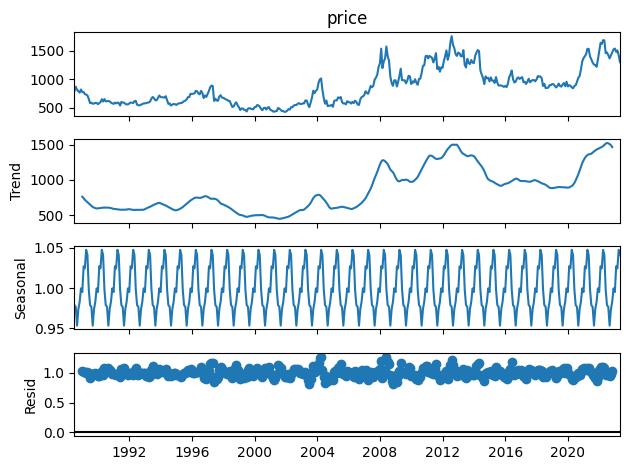

In [19]:
decomposition_mult.plot();

Se ve un salto en el precio post 2005, no tengo claro si indica tendencia. Verifico con ADF a continuación.

Se nota una clara estacionalidad anual (seasonality).

Se ve que los residuos oscilan alrededor del 0.


# ARIMA

Con la siguiente transformación puedo sacar la estacionalidad para aplicar ARIMA si quisiera, así que pruebo hacerlo y correr un modelo ARIMA:

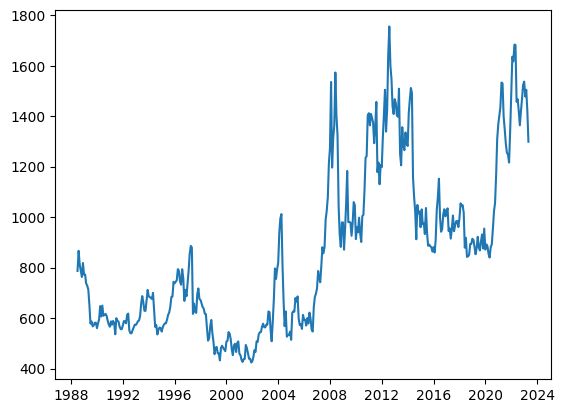

In [20]:
y_arima=df.price-decomposition_mult.seasonal
plt.plot(df.price-decomposition_mult.seasonal);

In [448]:
y_arima_diff=y_arima.diff(10).dropna()

In [449]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(y_arima_diff)[1])

p-value:  9.926030137474865e-05


## AR

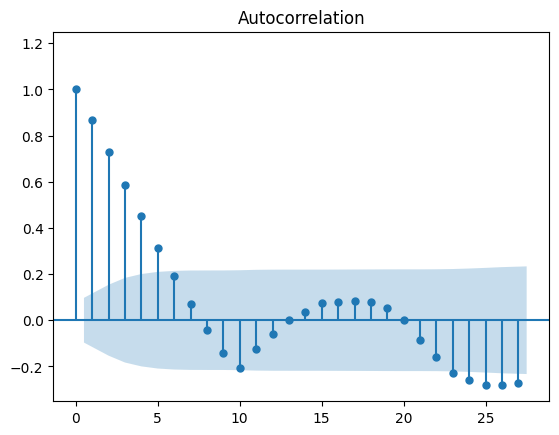

In [450]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y_arima_diff, auto_ylims=True);

## MA

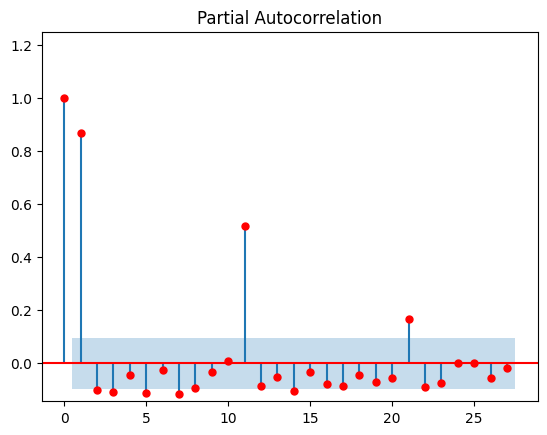

In [451]:
plot_pacf(y_arima_diff, method='ywm', auto_ylims=True, c='r');

## Model

In [452]:
from statsmodels.tsa.arima.model import ARIMA

# 1. initialize the model
arima = ARIMA(y_arima, order=(1, 1,3), trend='t')

# 2. fit the models
arima = arima.fit()

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  419
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -2365.831
Date:                Sat, 01 Jul 2023   AIC                           4743.663
Time:                        16:34:20   BIC                           4767.876
Sample:                    07-01-1988   HQIC                          4753.235
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2261      3.713      0.330      0.741      -6.051       8.503
ar.L1         -0.7673      0.148     -5.172      0.000      -1.058      -0.477
ma.L1          0.7907      0.149      5.315      0.000       0.499       1.082
ma.L2          0.0290      0.044      0.657      0.511      -0.058       0.116
ma.L3         -0.0637      0.042     -1.517      0.129      -0.146       0.019
sigma2      4825.9944    201.171     23.990      0.000    4431.707    5220.282
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               438.22
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.24   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions

In [453]:
from statsmodels.graphics.tsaplots import plot_predict

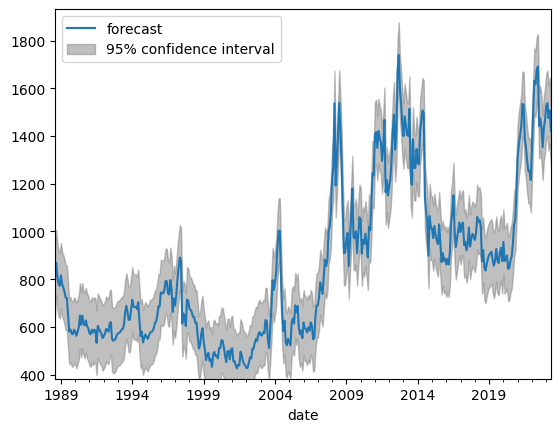

In [454]:
# Actual vs Fitted
plot_predict(arima, start=1, dynamic=False);
plt.ylim((.9 * y.min(), 1.1 * y.max()));

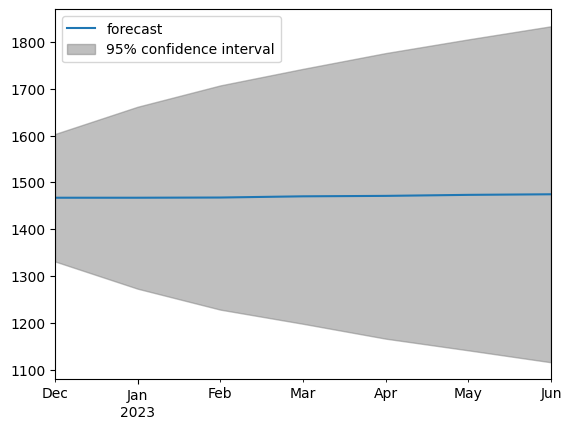

In [475]:
plot_predict(arima, start=413, end=419, dynamic=True)
plt.legend(loc='upper left');

In [456]:
len(y_arima)*0.85

356.15

In [457]:
y_train = y_arima[:413]
y_test = y_arima[413:]
arima = ARIMA(y_train, order=(1, 1, 3), trend='t').fit()

In [458]:
forecast_results = arima.get_forecast(6, alpha=0.05)

/home/tomiq/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [459]:
forecast = forecast_results.predicted_mean.reset_index(drop=True)
# forecast = arima.forecast(30, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

In [460]:
print(forecast, y_test)

0    1467.365919
1    1467.381532
2    1467.812458
3    1470.383036
4    1471.327812
5    1473.507944
Name: predicted_mean, dtype: float64 date
2022-12-01    1523.000283
2023-01-01    1537.004825
2023-02-01    1477.972812
2023-03-01    1504.475376
2023-04-01    1418.202304
2023-05-01    1298.708755
Freq: MS, dtype: float64


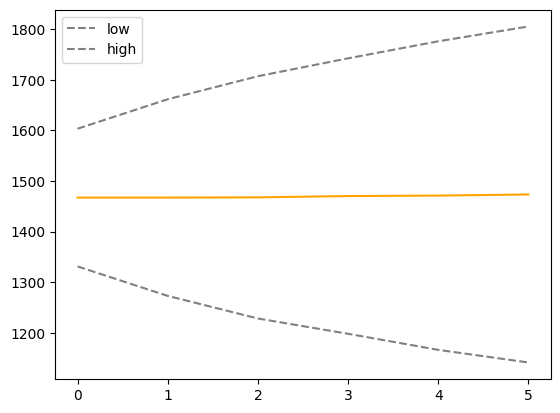

In [461]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='grey', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend();

In [462]:
forecast.index = y_test.index
conf_int.index = y_test.index

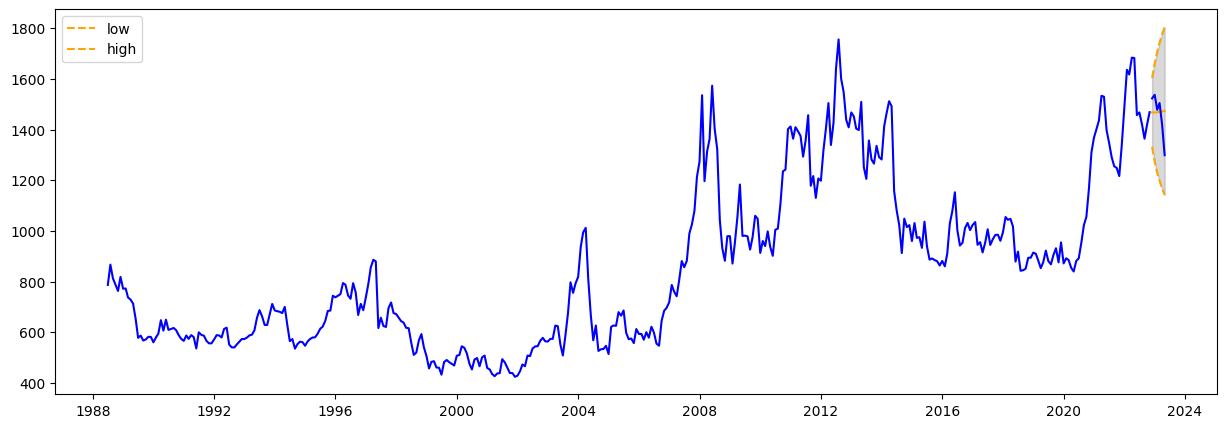

In [463]:
plt.figure(figsize=(15,5))

plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='orange', ls='--')
plt.plot(conf_int['high'], label='high', c='orange', ls='--')
plt.plot(y_train, c='blue')
plt.plot(y_test, c='blue')

plt.legend()
plt.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15);

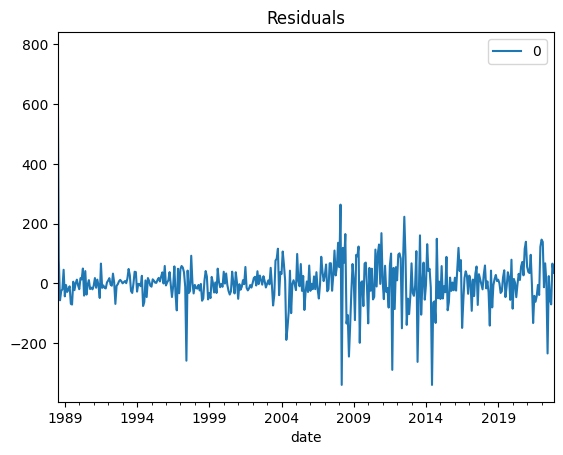

In [464]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals");

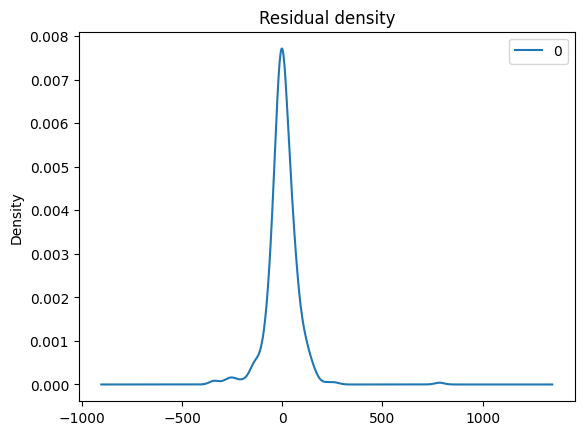

In [465]:
residuals.plot(kind='kde', title='Residual density');

## Evaluate

In [466]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [467]:
forecast_accuracy(forecast, y_test)

{'mape': 0.04723616233779356,
 'me': 9.735724385757067,
 'mae': 66.23917439789216,
 'mpe': 0.010115289403352615,
 'rmse': 84.24684135389978,
 'corr': -0.894761384227972,
 'minmax': 0.04434962157743083}

### MAPE ARIMA para M+1

Creo un loop que entrene sobre todos los datos disponibles hasta Junio de 2016 (para la primera iteración) y prediga el mes inmediatamente posterior (en este caso Julio de 2016) y lo guarde en la lista y_pred=[], en la segunda iteración arima entrene con todos los datos hast Julio de 2016 (80% de mis datos para train) y prediga agosto de 2016 y lo agregue a la lista y_pred. Así sucesivamente hasta llegar a predecir Mayo de 2023 entrenando sobre la totalidad de mi dataset menos el último dato.
Posteriormente obtengo el MAPE comparando mi y_pred con el y_true.

In [468]:
df.index[335]

Timestamp('2016-06-01 00:00:00')

In [469]:
df["price_arima"]=y_arima

In [470]:
train_data=df[df.index<="2016-06-01"]
validation_data=df[df.index>="2016-07-01"]

In [471]:
model=ARIMA(train_data["price_arima"],order=(1,1,3))
model_fit=model.fit()

In [472]:
y_pred = []
y_true = validation_data['price_arima'].tolist()
for i in range(len(validation_data)):
    # Obtener los datos hasta el mes anterior
    train_subset = df[df.index < validation_data.index[i]]
    
    # Ajustar el modelo ARIMA con los datos hasta el mes anterior
    model = ARIMA(train_subset['price_arima'], order=(1, 1, 3))
    model_fit = model.fit()
    
    # Realizar la predicción para el mes m+1
    prediction = model_fit.forecast(steps=1,alpha=0.05)[0]
    y_pred.append(prediction)

/home/tomiq/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomiq/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomiq/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning

In [473]:
# Calcular el MAPE
mape_values = []
for i in range(len(y_pred)):
    mape = abs(y_pred[i] - y_true[i]) / abs(y_true[i]) * 100
    mape_values.append(mape)

average_mape = sum(mape_values) / len(mape_values)
print('MAPE [%]:', average_mape)

MAPE [%]: 4.390355727748913


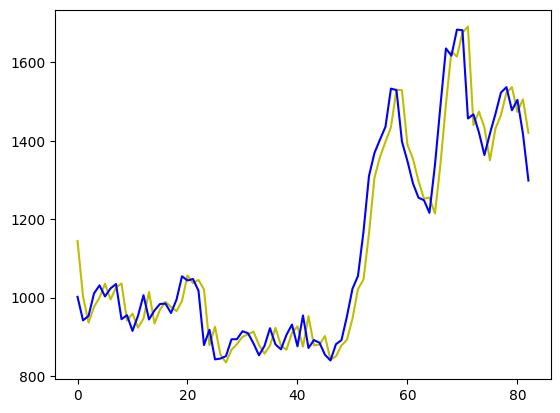

In [476]:
plt.plot(y_pred,c="y");
plt.plot(y_true,c="b");

## MAPE ARIMA para M+3

In [499]:
y_true_3=[]
for i in range(len(validation_data)-2):
    y_true_3.append([validation_data["price_arima"][i],validation_data["price_arima"][i+1],validation_data["price_arima"][i+2]])
y_true_3=np.array(y_true_3)

In [508]:
y_pred = []
# Iterar desde Julio de 2016 hasta Febrero de 2023
start_date = pd.Timestamp('2016-07-01')
end_date = pd.Timestamp('2023-02-01')
current_date = start_date

while current_date <= end_date:
    # Obtener los datos hasta la fecha actual
    train_data = df[df.index < current_date]
    
    # Ajustar el modelo ARIMA con los datos hasta la fecha actual
    model = ARIMA(train_data['price_arima'], order=(1, 1, 3))
    model_fit = model.fit()
    
    # Realizar la predicción para los próximos 3 meses
    forecast1 = model_fit.forecast(steps=1)[0]
    forecast2 = model_fit.forecast(steps=2)[0]
    forecast3 = model_fit.forecast(steps=3)[0]
    pred=[forecast1,forecast2,forecast3]
    y_pred.append(pred)
    
    # Avanzar al siguiente mes
    current_date += pd.DateOffset(months=1)

In [510]:
import numpy as np

# Calcular el MAPE para cada trío de predicciones
mape_trios = []
for i in range(len(y_pred)):
    mape_trio = np.mean(np.abs((y_pred[i] - y_true_3[i]) / y_true_3[i]) * 100)
    mape_trios.append(mape_trio)

# Calcular el MAPE general
mape_general = np.mean(mape_trios)

# Imprimir los MAPEs
print("MAPE por trío de predicciones:")
print(mape_trios)
print("MAPE general:")
print(mape_general)

MAPE por trío de predicciones:
[18.617615924500782, 4.16875133929723, 6.149167825214075, 3.818546632155034, 1.8640000004860344, 1.4871470565649823, 3.9634573914619757, 5.59923533058208, 10.454935709852286, 1.8701490220143056, 3.364344390296752, 4.541452524217483, 2.7673067314060495, 5.173558004691418, 4.5654644074537165, 1.3065255379963052, 1.3180746797849954, 3.6207895198134605, 6.289924281112985, 5.4117500882858565, 1.9608861866508025, 6.960807626814444, 11.823917823757377, 16.162988417356804, 4.206998330779136, 9.433013615244436, 1.9865224754891206, 5.059784335457426, 3.7156669072147124, 2.6672272333328717, 1.4922323406991616, 3.057237361847987, 4.880677641705625, 2.6696187985601476, 3.983609964052605, 2.0867678311438866, 4.36050992801848, 3.3179425209665063, 4.026650273063361, 3.6156774634845896, 5.026502426545732, 3.537994022849863, 7.928292846240207, 1.697171825924378, 2.8062483991608898, 5.116551182589509, 3.441612922444398, 6.281412034666822, 7.844447726847309, 11.4683795654351

## MAPE ARIMA para M+6

In [500]:
y_true_6=[]
for i in range(len(validation_data)-5):
    y_true_6.append([validation_data["price_arima"][i],validation_data["price_arima"][i+1],validation_data["price_arima"][i+2],
                     validation_data["price_arima"][i+3],validation_data["price_arima"][i+4],validation_data["price_arima"][i+5]])
y_true_6=np.array(y_true_6)

In [511]:
y_pred = []
# Iterar desde Julio de 2016 hasta Noviembre de 2022
start_date = pd.Timestamp('2016-07-01')
end_date = pd.Timestamp('2022-11-01')
current_date = start_date

while current_date <= end_date:
    # Obtener los datos hasta la fecha actual
    train_data = df[df.index < current_date]
    
    # Ajustar el modelo ARIMA con los datos hasta la fecha actual
    model = ARIMA(train_data['price_arima'], order=(1, 1, 3))
    model_fit = model.fit()
    
    # Realizar la predicción para los próximos 6 meses
    forecast1 = model_fit.forecast(steps=1)[0]
    forecast2 = model_fit.forecast(steps=2)[0]
    forecast3 = model_fit.forecast(steps=3)[0]
    forecast4 = model_fit.forecast(steps=4)[0]
    forecast5 = model_fit.forecast(steps=5)[0]
    forecast6 = model_fit.forecast(steps=6)[0]
    pred=[forecast1,forecast2,forecast3,forecast4,forecast5,forecast6]
    y_pred.append(pred)
    
    # Avanzar al siguiente mes
    current_date += pd.DateOffset(months=1)

In [519]:
(abs(y_pred[0]-y_true_6[0])/y_true_6[0])*100

array([14.23563716, 21.51132874, 20.10588188, 13.24612992, 10.99601364,
       14.12410426])

In [512]:
import numpy as np

# Calcular el MAPE para cada sixteto de predicciones
mape_sixes = []
for i in range(len(y_pred)):
    mape_six = np.mean(np.abs((y_pred[i] - y_true_6[i]) / y_true_6[i]) * 100)
    mape_sixes.append(mape_six)

# Calcular el MAPE general
mape_general = np.mean(mape_sixes)

# Imprimir los MAPEs
print("MAPE por sixtetos de predicciones:")
print(mape_sixes)
print("MAPE general:")
print(mape_general)

MAPE por sixtetos de predicciones:
[15.703182599955488, 2.871920629284411, 7.206764154657367, 4.174097523463562, 3.2457046632970687, 5.932285514052029, 4.871390296304853, 6.397226282798427, 8.783331397162277, 2.496464597649135, 2.500251419789771, 5.087891826078049, 2.897485837136678, 4.366472926673989, 5.6752437200166845, 3.608327320576919, 3.4953516580946498, 4.680321689891869, 6.940001792911999, 6.6041412787181315, 11.084623304489845, 13.280179322512241, 17.68685989532402, 17.25966141475804, 3.216733938393221, 6.113339229731636, 3.8443574168780867, 6.269669808553229, 3.2105300930208327, 2.0167589469462546, 2.5051615934317653, 2.8601770687785653, 4.086728574671491, 2.0496196933317794, 4.414488667003628, 2.5458723546740445, 3.780183431474874, 3.142265511869106, 4.084933322857071, 3.361946862999107, 5.375494794961473, 3.0613925106449353, 9.476030578562474, 1.9193185487518416, 2.8940471497339435, 5.603816440361457, 9.985979953508192, 13.71058302130645, 16.358936719684692, 20.767785667070

## Fine Tuning

In [410]:
import pmdarima as pm

model = pm.auto_arima(
    y_train, 
    start_p=0, max_p=1,
    start_q=0, max_q=6, 
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4727.619, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4729.591, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4729.592, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4725.815, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4731.577, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.158 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  418
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2361.908
Date:                Sat, 01 Jul 2023   AIC                           4725.815
Time:                        15:24:28   BIC                           4729.849
Sample:                    07-01-1988   HQIC                          4727.410
                         - 04-01-2023                                       

In [218]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


range_p = [0, 1]
range_d = [1]
range_q = [0, 1, 2, 3, 4, 5, 6]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
y = y_arima.astype('float32')

for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)

    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]

        # Using SARIMAX without seasonality or exogenous variables is equivalent to using ARIMA
        # SARIMAX's fit method comes with a maxiter keyword, useful to avoid warnings
        model = SARIMAX(y_train, order=order).fit(maxiter=75, disp=False)
        # model = ARIMA(y_train, order=order).fit()
        y_pred = model.forecast(len(y_test))

        r2s.append(r2_score(y_test, y_pred))
        orders.append(order)
        aics.append(model.aic)
        
        
df2 = pd.DataFrame(list(zip(fold_idxs, orders, aics, r2s)), columns =['Fold', '(p, d, q)', 'AIC', 'R2'])

/home/tomiq/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomiq/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [219]:
df2.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

(p, d, q)
(0, 1, 0)    2266.547668
(1, 1, 3)    2267.564500
(1, 1, 0)    2267.864077
(0, 1, 1)    2267.901080
(1, 1, 2)    2268.669433
(1, 1, 4)    2269.325737
(0, 1, 3)    2269.376933
(0, 1, 2)    2269.692805
(1, 1, 1)    2269.852757
(1, 1, 5)    2269.960969
(0, 1, 4)    2270.021250
(0, 1, 5)    2270.513587
(1, 1, 6)    2271.310271
(0, 1, 6)    2271.479031
Name: AIC, dtype: float64

# Conclusiones

* MAPE del 8,17% está bien para 6 meses (baseline ~12%),

* MAPE del 6,19% es mejor que el para 3 meses (baseline ~9,5%),

* y 4,39% para el M+1 tmb ok vs. baseline ~5%

Continuo entonces con mi serie con estacionalidad para SARIMA:

In [129]:
print('p-value: ', adfuller(y)[1])

p-value:  0.2815639019905054


p-value > 0.05, por lo que concluyo que existe tendencia (there's no stationarity)

In [135]:
print('p-value: ', adfuller(y.diff(1).dropna())[1])

p-value:  0.0


In [136]:
print('p-value: ', adfuller(y.diff(1).fillna(0))[1])

p-value:  0.0


In [137]:
print('p-value: ', adfuller(y.diff(1).diff(1).fillna(0))[1])

p-value:  2.8806952103410626e-15


Pruebo con diferenciación simple, pero el p-value baja demasiado rápido y no parece el mejor méotodo (no hace falta segunda diferenciación):

Parece mejor y más lógico el resultado con diferenciación cada 12 meses (diferenciación estacional):

In [150]:
print('p-value: ', adfuller(y.diff(12).dropna())[1])

p-value:  4.991299484142456e-05


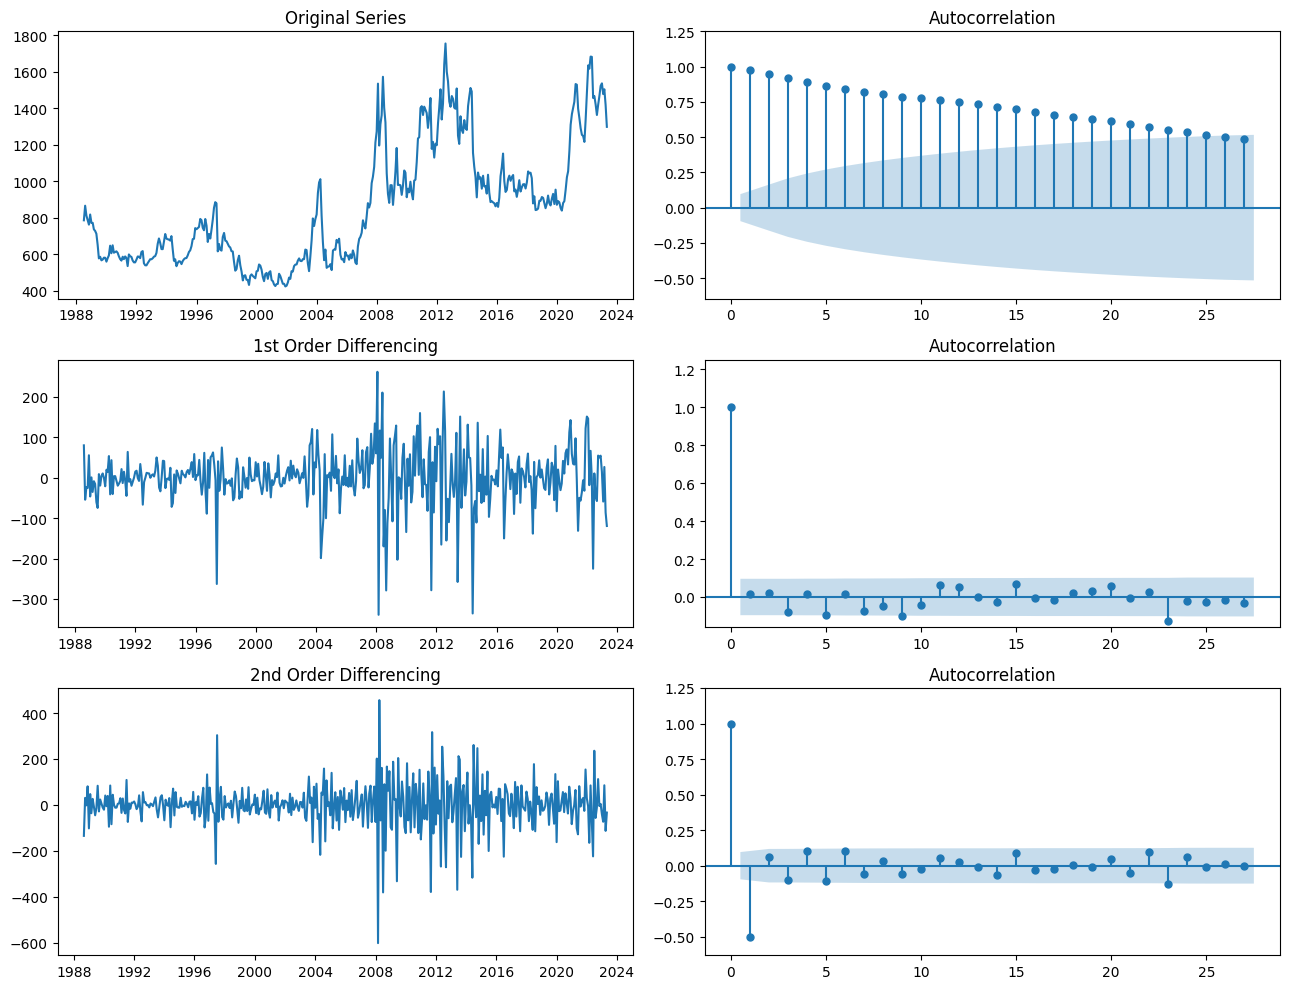

In [132]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(13,10))
axes[0, 0].plot(y); axes[0, 0].set_title('Original Series')
plot_acf(y, auto_ylims=True,ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.diff().dropna(), auto_ylims=True,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.diff().diff().dropna(), auto_ylims=True, ax=axes[2, 1])

plt.tight_layout()

Pruebo aplicar transformación logarítmica en función de la notebook de Tomi, pero obtengo prácticamente el mismo resultado que cuando hacía diferenciación directamente sin logaritmizar:

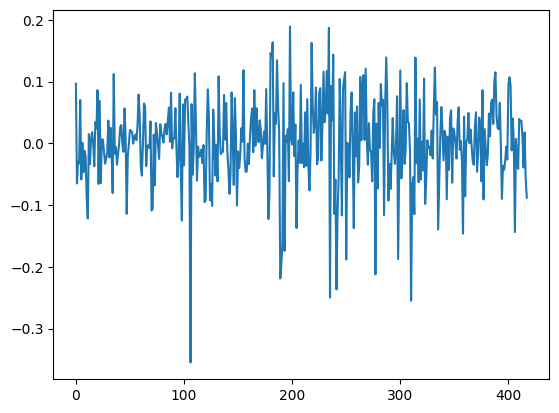

p-value: 0.000000


In [236]:
y_log = np.log(y)
y_log_diff = np.diff(y_log)
plt.plot(y_log_diff)
plt.show()

# Re-Chequeo Stationarity
result = adfuller(y_log_diff)
print('p-value: %f' % result[1])

Finalmente decido continuar con la opción de diferenciar vs el valor del mismo mes del año anterior, de esa manera obtengo un resultado más lógico:

In [151]:
y_diff_seasonal = y.diff(12).dropna()

In [152]:
result = adfuller(y_diff_seasonal)
print('p-value: %f' % result[1])

p-value: 0.000050


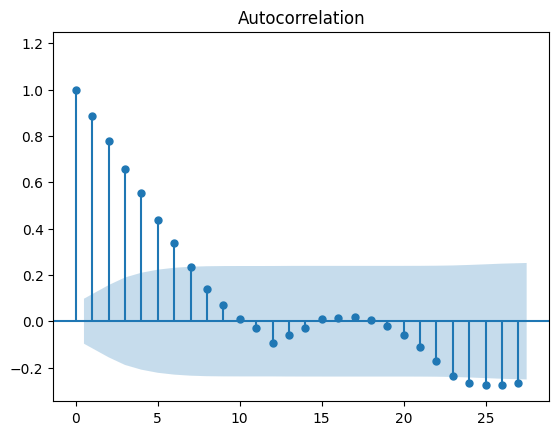

In [153]:
plot_acf(y_diff_seasonal, auto_ylims=True);

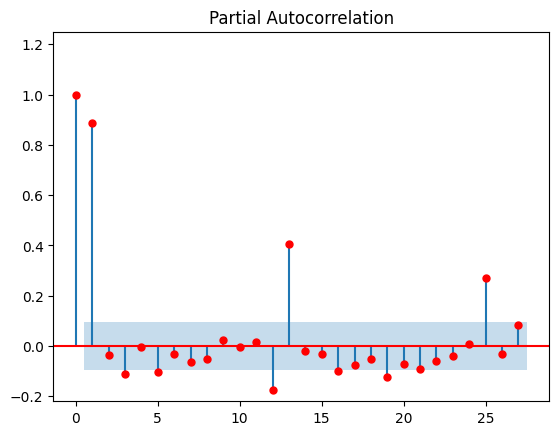

In [154]:
plot_pacf(y_diff_seasonal, method='ywm', auto_ylims=True, c='r');

#### Train-Test Split y análisis de train data

In [358]:
df_train = df[:'2017']
df_test = df['2017':]
print(df_train.shape)
print(df_test.shape)

(354, 2)
(77, 2)


In [359]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(df_train["price"])[1])

p-value:  0.2147469297991792


p-value:  4.581342570356015e-05


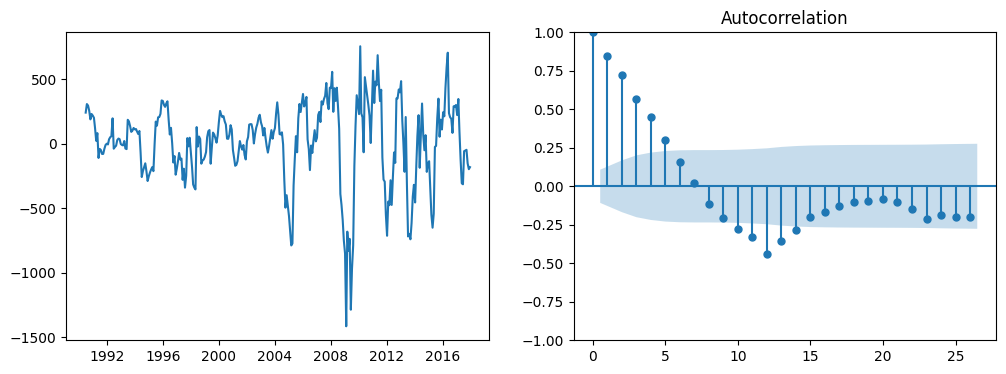

In [377]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

y_diff_12 = df_train.price.diff(12).diff(12).dropna() #D=2 y d=0, con d=1 q=0

axes[0].plot(y_diff_12)
plot_acf(y_diff_12, ax=axes[1])

print('p-value: ', adfuller(y_diff_12)[1])

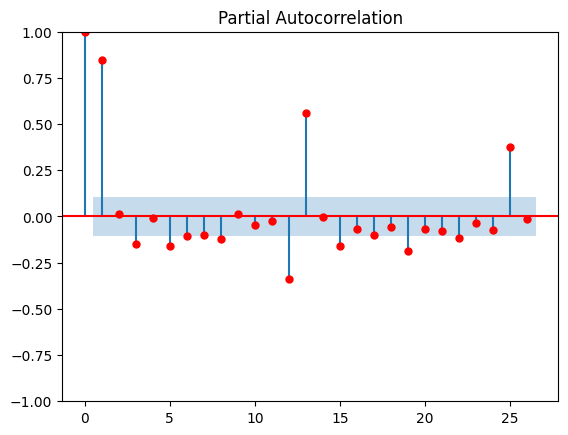

In [382]:
plot_pacf(y_diff_12, method='ywm',c='red');

In [383]:
model = pm.auto_arima(
    df_train['price'],
    m=12, # frequency of series. Important to choose manually
    seasonal=True,
    stepwise=True,  # only check the most interesting combination. False will take way longer.
    start_p=0, max_p=2,
    start_d=0, max_d=1,
    start_q=0, max_q=6,
    start_P=0, max_P=2,
    start_D=0, max_D=2,
    start_Q=0, max_Q=6,
    njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4008.071, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4011.304, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4011.295, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4006.088, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=4009.621, Time=0.17 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4009.613, Time=0.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4011.575, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4009.782, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4009.776, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4007.381, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.594 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  354
Model:               SARIMAX(0, 1, 0)   Log Likelih